### Saving models

In practice, training typically takes several hours, days or even weeks. In this unit, we will see how to save our models and their trained parameters with Keras. This allows us to use them again at a later timepoint and gives us the possibility to easily share them with others.

#### Keras pretrained model
Let’s start by loading tensorflow and keras

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K

In this code, we also import Keras backend module that is usually named K. So far, we let Keras do the house keeping with our models: add the layers, variables and operations to the network. However, we will now work with large models that have several millions of parameters. For this reason, we will avoid cluttering by manually resetting all the states with K.clear_session()



In [3]:
K.clear_session()  # Reset state generated by Keras (avoid clutter)

Once the session is cleared, we can go ahead and import the Xception ConvNet from the Keras applications module.

In [4]:
model = keras.applications.Xception(weights="imagenet")

91897856/91884032 [==============================] - 8s 0us/step


Note that we not only load the network architecture but also its pretrained parameters that are the result of a prior training process on the ImageNet data set. To get a complete list of available models, see the Keras applications reference.

Let’s take a look at the model:

In [6]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

You should see that the model has a very large number of layers compared to what we’ve seen in this course. It’s out of the scope of this course to understand its architecture, however, you should recognize some familiar layers such as Conv2D, MaxPooling2D and a Dense at the end of the network for the final classification. Overall, the network has 23 million parameters.

#### Sample image predictions
The network was trained to recognize a thousand predefined categories. Let’s pass a sample image through the network to see if it can recognize it. First, we need to load the image (available in the resources) with PIL.

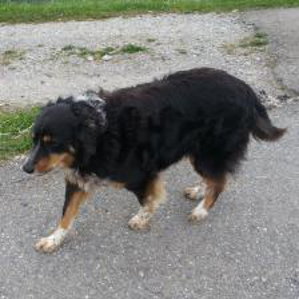

In [8]:
%matplotlib inline
import PIL.Image as Image
from IPython.display import display

img = Image.open("c4_photo.jpg").resize(size=[299, 299])
display(img)

The Xception network works with 299x299 images, so we call resize() to ensure that it has the correct size - you can always refer to the tf.keras.applications.Xception documentation to get details about the expected image formats.

We can then convert the image into a Numpy array. Neural networks work with batches of images. For this reason, we need to add a new dimension for the number of images which in our case is one.

In [9]:
import numpy as np

img_batch = np.array(img)[np.newaxis, :, :, :]
print("Batch size:", img_batch.shape)
print("Data type:", img_batch.dtype)

Batch size: (1, 299, 299, 3)
Data type: uint8


Let’s now compute the predictions with predict()

In [11]:
predictions = model.predict(2*(img_batch-127.5)/255)
predictions.shape


(1, 1000)

The network also requires the values to be between -1 and 1, so we need to transform the data with 2 * (x - 127.5) / 255 before calling the function. We get one probability per class - this corresponds to a softmax output.

Let’s take a look at the predictions for the first 5 classes.

In [12]:
print(predictions[0, :5])

[0.00026001 0.00031556 0.0006608  0.00044154 0.00019407]


We can retrieve the overall top N predictions with decode_predictions(.. , N)

In [13]:
from tensorflow.keras.applications.xception import decode_predictions

decode_predictions(predictions, top=5)

49152/35363 [=========================================] - 0s 0us/step


[[('n02107683', 'Bernese_mountain_dog', 0.25143233),
  ('n02107908', 'Appenzeller', 0.06188093),
  ('n02108551', 'Tibetan_mastiff', 0.04925464),
  ('n02106030', 'collie', 0.04796499),
  ('n02106166', 'Border_collie', 0.040270224)]]

In these top-5 classes, the Bernese mountain, Tibetan mastiff, and Appenzeller dog breeds look very similar to the one from the picture.

#### Save and load models with the help of h5 files
Keras models have a save() method which allows us to save the network architecture and weights in a single binary file. We actually have two different formats to save the Keras models. We will use the .h5 format here, which provides a light-weight alternative compared to the default format.



In [14]:
model.save("model.h5")  # Saves architecture and weights

C:\Users\56975\anaconda3\envs\adsml\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


You might get warnings after running the cell above because the saved model was not compiled. You can run model.compile(optimizer='sgd', loss='categorical_crossentropy') before saving the model to avoid warnings. All remaining warnings can be ignored.

If you check the size of the file, you should see that this model is around 100MB.



In [18]:
# From the windows commmand
# dir model.h5

To load a saved model, we can use load_model(). Let’s reset Keras state again, load the model from the file and verify that we can get the same predictions as before

In [16]:
K.clear_session()  # Reset state generated by Keras to avoid clutter
new_model = keras.models.load_model("model.h5", compile=False)  # Load model

# New predictions
decode_predictions(new_model.predict(2*(img_batch-127.5)/255))

[[('n02107683', 'Bernese_mountain_dog', 0.25143233),
  ('n02107908', 'Appenzeller', 0.06188093),
  ('n02108551', 'Tibetan_mastiff', 0.04925464),
  ('n02106030', 'collie', 0.04796499),
  ('n02106166', 'Border_collie', 0.040270224)]]